- x leave running for 10+ hours to get ~50,000 tweets 
- x use keywords for scraping filter = ['trump','bush','cruz','kasich','rubio','clinton','sanders'] 
- look at top/bottom tweets for each candidate to assess quality of sentiment analysis 
- x Check sentiment analysis 
    - if sentiment analysis looks innaccurate - does it still correlate with favorable/unfavorable ranking (different from voting - how do you like them) Real Clear Politics does an average
- x how many pos/neg tweets per candidate --- compare against number of tweets, so could say ok trump has most tweets, but not all positive 
- compare 'who's winning on twitter' with poll data 
- can conclude candidate more popular on twitter than in polls, alt. is that twitter is good predictor for poll data 
- what are common topics ... topic clustering - does it vary by candidate? 

# First pass at exploring Twitter scraping
- used tweepy to scrape the data & output json file 

In [82]:
from pymongo import MongoClient
import json
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import numpy as np
import tweetExplore_fns as fns
import importlib
import matplotlib
import matplotlib.pyplot as plt

importlib.reload(fns);
%matplotlib inline



## organizing the data

In [43]:
#  import data 
# with open('raw_tweets10min.json') as data_file:
# with open('../data/raw_tweetsfilter10min_poli.json') as data_file:
# with open('raw_tweets10min_loc.json') as data_file:
# with open('raw_tweets40min_bosSC.json') as data_file:
with open('../data/raw_tweets40min_candidates.json') as data_file:

    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N coordinates:',len(coord_index_list), 'N Tweets', len(tweet_list))

N coordinates: 48 N Tweets 54328


## Trying out the textblob sentiment analysis

In [44]:
from textblob import TextBlob

candidates = ['trump','bush','cruz','kasich','rubio','clinton','sanders'] #track list

# for each candidate
index_store = []
subjectivity_store = []
polarity_store = []
for iperson,val in enumerate(candidates):
    # save each candidate's list of polarity etx. in a list 
    person_sentiment_polarity, person_sentiment_subjectivity, person_tweetInd = fns.extract_sentiment(tweet_list,candidates[iperson])
    polarity_store.append(person_sentiment_polarity)
    subjectivity_store.append(person_sentiment_subjectivity)
    index_store.append(person_tweetInd)

trump   # tweets: 24625 avg polarity: 0.0870767894274
bush   # tweets: 5082 avg polarity: 0.0581402601325
cruz   # tweets: 6112 avg polarity: 0.0694175003762
kasich   # tweets: 1246 avg polarity: 0.114294507826
rubio   # tweets: 7264 avg polarity: 0.0726682045224
clinton   # tweets: 5915 avg polarity: 0.0907033811296
sanders   # tweets: 4708 avg polarity: 0.0614936130122


In [45]:
# sort tweets into positive/negative for each candidate 
# for each candidate
store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []

for person,val in enumerate(candidates):
    pos_polarity = []
    ind_pos_polarity = []
    tweet_pos_polarity = []
    neg_polarity = []
    ind_neg_polarity = []
    tweet_neg_polarity = []
    current_polarity = polarity_store[person]
    current_indices = index_store[person]
    for i,val in enumerate(current_polarity):
        if val > 0: 
            pos_polarity.append(current_polarity[i])
            ind_pos_polarity.append(current_indices[i])
            tweet_pos_polarity.append(tweet_list[current_indices[i]]['text'])
        else:
            neg_polarity.append(current_polarity[i])
            ind_neg_polarity.append(current_indices[i])
            tweet_neg_polarity.append(tweet_list[current_indices[i]]['text'])
            
    store_pos_polarity.append(pos_polarity)
    store_ind_pos_polarity.append(ind_pos_polarity)
    store_tweet_pos_polarity.append(tweet_pos_polarity)
    store_neg_polarity.append(neg_polarity)
    store_ind_neg_polarity.append(ind_neg_polarity)
    store_tweet_neg_polarity.append(tweet_neg_polarity)
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    print(candidates[person],'# positive tweets',len(ind_pos_polarity),'# negative tweets:',len(ind_neg_polarity),
          'avg + sentiment:',np.average(pos_polarity),'avg - sentiment:',np.average(neg_polarity))

trump # positive tweets 10102 # negative tweets: 14523 avg + sentiment: 0.360710805533 avg - sentiment: -0.1032592865
bush # positive tweets 1705 # negative tweets: 3377 avg + sentiment: 0.306347149305 avg - sentiment: -0.0671759216974
cruz # positive tweets 2247 # negative tweets: 3865 avg + sentiment: 0.363059933223 avg - sentiment: -0.101297776883
kasich # positive tweets 495 # negative tweets: 751 avg + sentiment: 0.353558534199 avg - sentiment: -0.0434094775989
rubio # positive tweets 2905 # negative tweets: 4359 avg + sentiment: 0.328425716512 avg - sentiment: -0.0977781300338
clinton # positive tweets 2461 # negative tweets: 3454 avg + sentiment: 0.326908272556 avg - sentiment: -0.0775943136594
sanders # positive tweets 1612 # negative tweets: 3096 avg + sentiment: 0.319519867855 avg - sentiment: -0.0728533904786


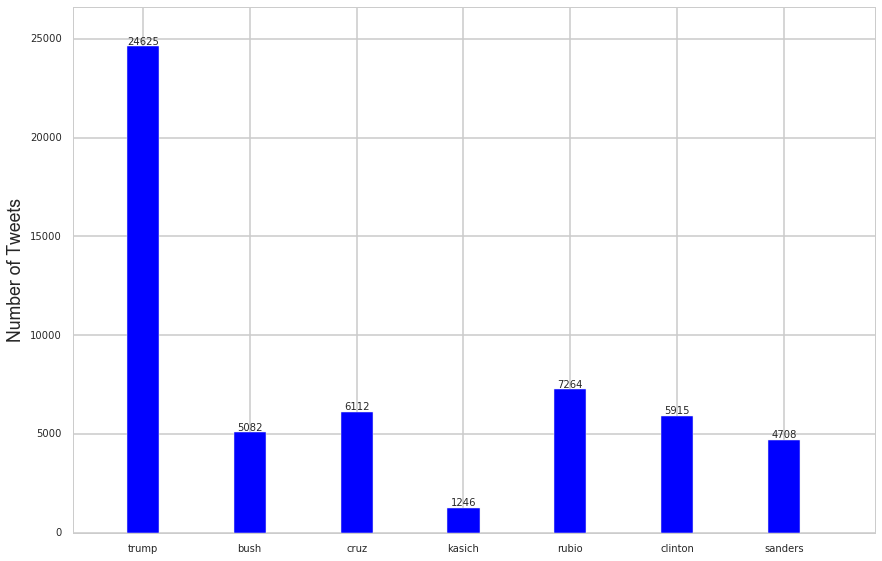

In [161]:
candidate_tweets = []
pos_tweets = []
neg_tweets = []
avg_pos = []
avg_neg = []
for i,val in enumerate(index_store):
    candidate_tweets.append(len(index_store[i]))
    pos_tweets.append(len(store_ind_pos_polarity[i]))
    neg_tweets.append(len(store_ind_neg_polarity[i]))
    avg_pos.append(np.average(store_pos_polarity[i]))
    avg_neg.append(np.average(store_neg_polarity[i]))
    
fig = plt.gcf()
matplotlib.rc('xtick',labelsize = 10)
matplotlib.rc('ytick',labelsize = 10)
ymax = np.max(candidate_tweets) + 2000

plt.xlim([.5,8])
plt.ylim([0,ymax])
# matplotlib.rc('ylabel',labelsize = 2b0)
plt.ylabel('Number of Tweets')
ind = np.arange(len(candidates))+1
def autolabelInt(rects):
    """attach labels to bars, integers"""
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height+.03,
                '%d' % int(height),
                ha='center', va='bottom')

width = .3
rect1 = plt.bar(ind, candidate_tweets, width, color = 'blue')
plt.xticks(ind + width/2, candidates);
autolabelInt(rect1);

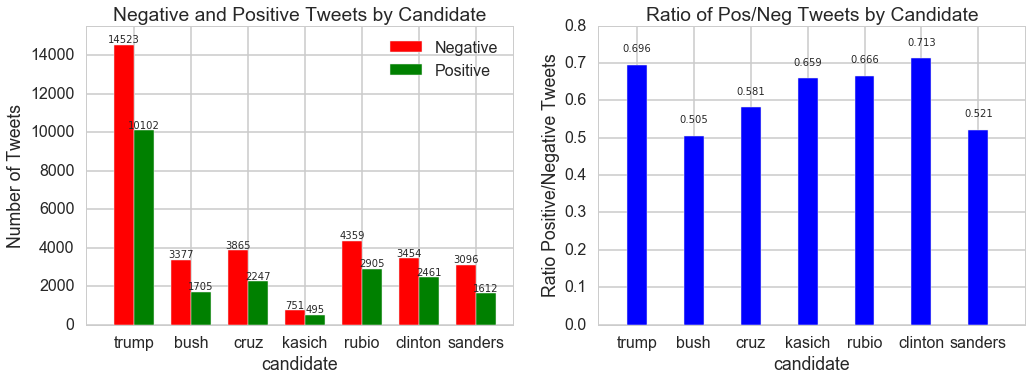

In [158]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
ax = [0,1]
ind = np.arange(len(candidates))+1
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])
rects1 = ax[0].bar(ind, neg_tweets, width, color='r') #, yerr=menStd
rects2 = ax[0].bar(ind + width, pos_tweets, width, color='g') #, yerr=womenStd

ymax = np.max([neg_tweets,pos_tweets]) + 1000

# add some text for labels, title and axes ticks
ax[0].set_title('Negative and Positive Tweets by Candidate')
ax[0].legend((rects1[0], rects2[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_ylabel("Number of Tweets")
ax[0].set_xticklabels(candidates)
ax[0].set_xlim([.5,8])
ax[0].set_ylim([0,ymax])
ax[0].set_xticks(ind+width)
# label bars with y value, integer
fns.autolabelInt(rects1,0,ax,neg_tweets)
fns.autolabelInt(rects2,0,ax,pos_tweets)

ax[1] = plt.subplot(gs[1])
ax[1].set_title('Ratio of Pos/Neg Tweets by Candidate')

rect1 = ax[1].bar(ind, pos_neg_ratio, width, color = 'blue')
ax[1].set_xlabel("candidate")
ax[1].set_ylabel("Ratio Positive/Negative Tweets")
ax[1].set_xticks(ind+width/2)
ax[1].set_xlim([.5,8])
ax[1].set_xticklabels(candidates) #rotation = 30

# label y value of bars, decimal 
fns.autolabelDec(rect1,1,ax,pos_neg_ratio)
plt.show();

interesting, Kasich has the least tweets, but the best pos/negative ratio 

what if we looked at the average positivity/negativity score? How positive are the positive tweets for each candidate? 

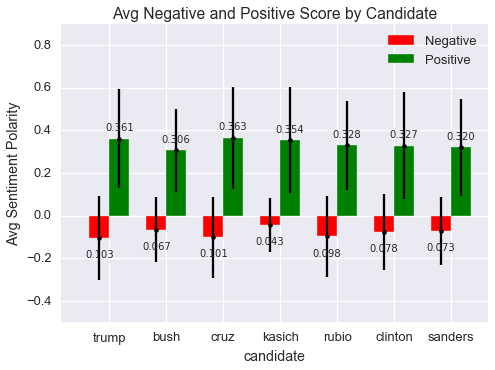

In [117]:
std_pos = []
std_neg = []
sterr_pos = []
sterr_neg = []
for i, val in enumerate(candidates):
    std_pos.append(np.std(store_pos_polarity[i]))
    std_neg.append(np.std(store_neg_polarity[i]))
    sterr_pos.append(np.std(store_pos_polarity[i])/np.sqrt(len(store_pos_polarity[i])))
    sterr_neg.append(np.std(store_neg_polarity[i])/np.sqrt(len(store_neg_polarity[i])))

ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
ax = [0,1]


ind = np.arange(len(candidates))+1
from matplotlib import gridspec
import seaborn as sns
sns.set_context("talk")
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax[0] = plt.subplot(gs[0])
rects1 = ax[0].bar(ind, avg_neg, width, color='r') #, yerr=menStd
rects2 = ax[0].bar(ind + width, avg_pos, width, color='g') #, yerr=womenStd
# add some text for labels, title and axes ticks
ax[0].set_title('Avg Negative and Positive Score by Candidate')
ax[0].legend((rects1[0], rects2[0]), ('Negative', 'Positive'))
ax[0].set_xlabel("candidate")
ax[0].set_ylabel("Avg Sentiment Polarity")
ax[0].set_xticklabels(candidates)
ax[0].set_xlim([.5,8])
ax[0].set_ylim([-.5,.9])
ax[0].errorbar(ind+width/2,avg_neg, yerr=std_neg,fmt='.', color = 'k')
ax[0].errorbar(ind+width*1.5,avg_pos, yerr=std_pos,fmt='.',color = 'k')
# ax[0].errorbar(ind+width/2,avg_neg, yerr=sterr_neg,fmt='.', color = 'k')
# ax[0].errorbar(ind+width*1.5,avg_pos, yerr=sterr_pos,fmt='.',color = 'k')

ax[0].set_xticks(ind+width)

# label bars with y value, integer

def autolabelDec(rects,axNum,ax,vals):
    """attach labels to bars, 3 decimals"""
    i = 0
    for rect in rects:        
        height = rect.get_height()
        if vals[i] > 0:
            ax[axNum].text(rect.get_x() + rect.get_width()/2., height+.03,
                '%0.3f' % height,
                ha='center', va='bottom')
        else:
            ax[axNum].text(rect.get_x() + rect.get_width()/2., -1*(height+.1),
                '%0.3f' % height,
                ha='center', va='bottom')
        i = i+1
fns.autolabelDec(rects1,0,ax,avg_neg)
fns.autolabelDec(rects2,0,ax,avg_pos)
sns.set_style('darkgrid')
rects1
plt.show();




(-0.05, 1.05)

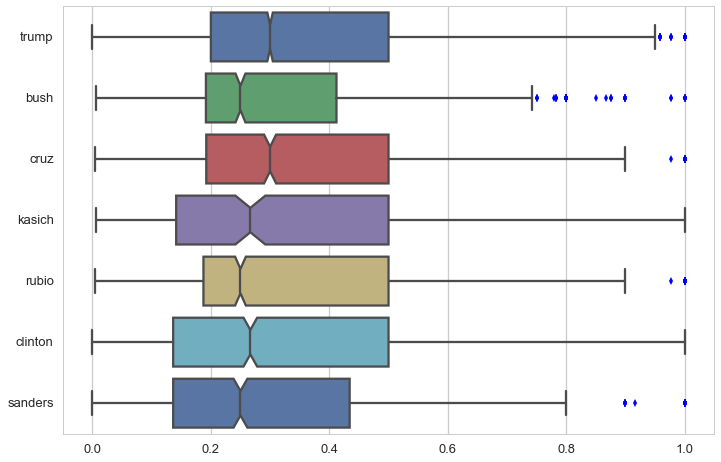

In [129]:
sns.set_style("whitegrid")
ax = sns.boxplot(data = store_pos_polarity, orient = "h", palette = "deep", notch = 1)
ax.set_yticklabels(candidates);
ax.set_xlim([-.05,1.05])

(-1.05, 0.05)

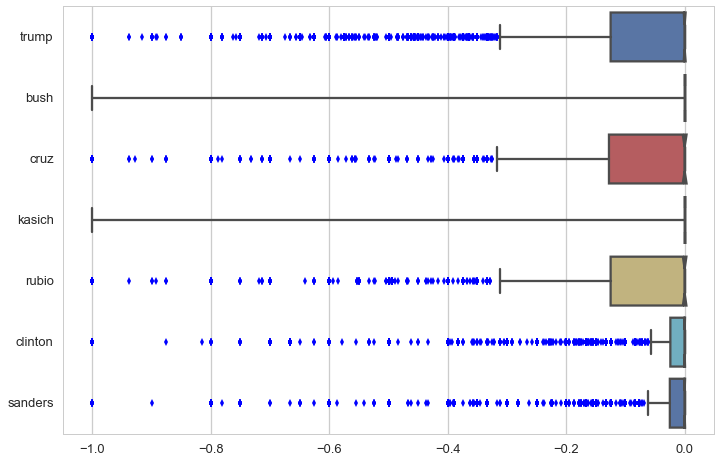

In [131]:
sns.set_style("whitegrid")
ax = sns.boxplot(data = store_neg_polarity, orient = "h", palette = "deep", notch = 1)
ax.set_yticklabels(candidates);
ax.set_xlim([-1.05,.05])

In [96]:
plt.style.available


['seaborn-darkgrid',
 'seaborn-colorblind',
 'seaborn-ticks',
 'bmh',
 'seaborn-white',
 'seaborn-deep',
 'seaborn-dark-palette',
 'dark_background',
 'ggplot',
 'grayscale',
 'seaborn-paper',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'seaborn-dark',
 'seaborn-notebook',
 'classic',
 'seaborn-muted',
 'seaborn-bright',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk']

//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


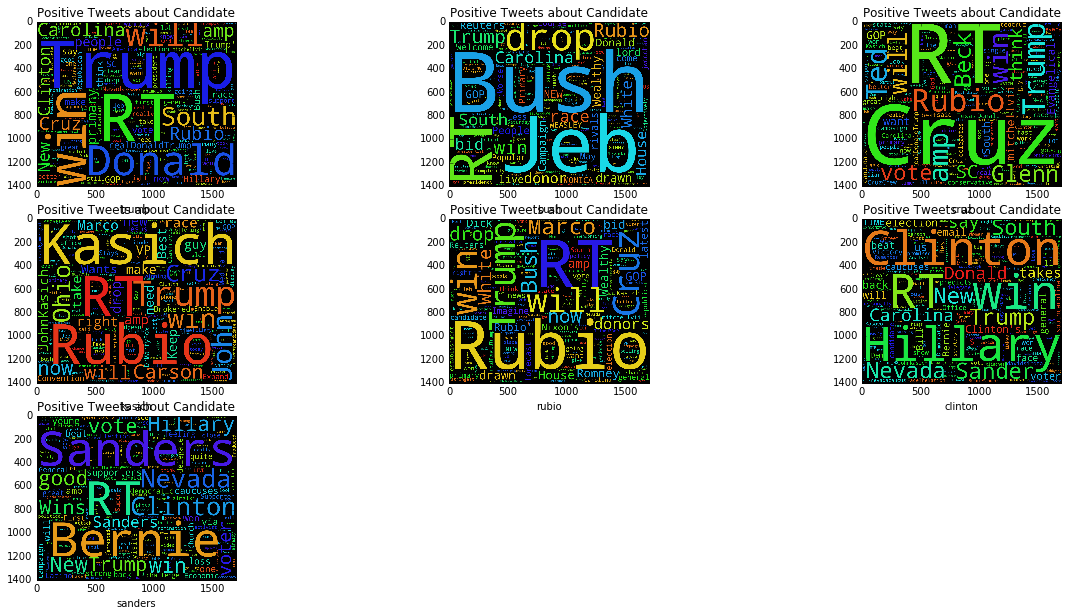

In [62]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
from matplotlib import gridspec
fig = plt.figure(figsize = (40,10)) #figsize=(90, 90)
ax = []
gs = gridspec.GridSpec(3, 3, width_ratios=[1]*len(candidates))
for i, val in enumerate(candidates):
    ax.append(plt.subplot(gs[i]))
    tempwordcloud = fns.makeWordcloud(store_tweet_pos_polarity[i])
    ax[i].imshow(tempwordcloud)
    # add some text for labels, title and axes ticks
    ax[i].set_title('Positive Tweets about Candidate')
    ax[i].set_xlabel(candidates[i])

plt.show()

correlation coefficient between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative: 0.291659895704


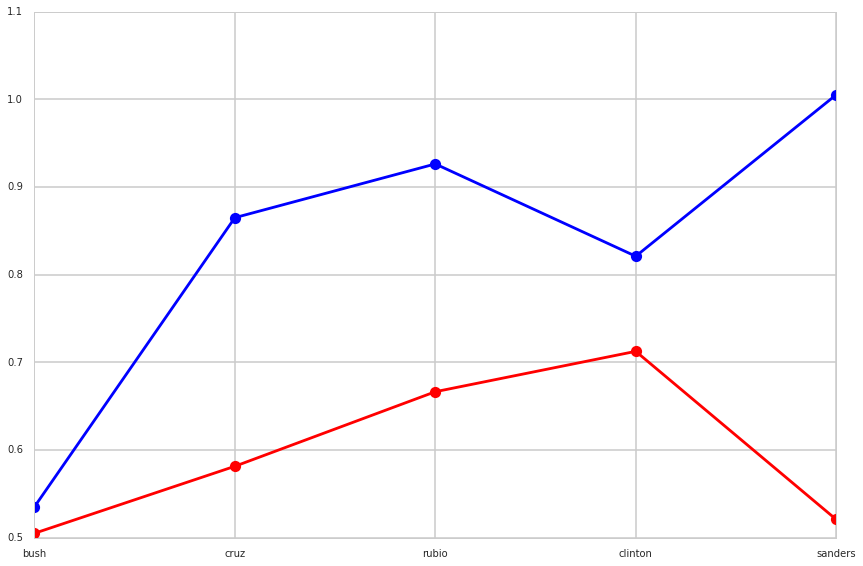

In [162]:
rcp_candidates = ['bush','cruz','rubio','clinton','sanders'] #'trump','kasich',#track list
rcp_inds = np.array([1,2,4,5,6])
rcp_pos_neg_ratio = []
xind = np.arange(len(rcp_candidates))
for i, vals in enumerate(rcp_inds):
    rcp_pos_neg_ratio.append(pos_neg_ratio[rcp_inds[i]])
    
rcp_favorable = np.array([29,34.6,35.2,42.2,38.4]) # accessed from Real Clear Politics 2/21/16
rcp_unfavorable = np.array([54.2,40,38,51.4,38.2]) # accessed from Real Clear Politics 2/21/16
type(rcp_unfavorable)
fav_unfav_ratio = rcp_favorable/rcp_unfavorable
# rcp_pos_corr = np.correlate(fav_unfav_ratio,rcp_pos_neg_ratio)
rcp_pearson_corr = np.corrcoef(fav_unfav_ratio,rcp_pos_neg_ratio)
plt.plot(xind,fav_unfav_ratio,c='b',marker = 'o')
plt.plot(xind,rcp_pos_neg_ratio,c='r',marker='o')
plt.xticks(xind, rcp_candidates)
sns.set_context("poster")
plt.show;
# print('cross correlation between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative:',
#      rcp_pos_corr[0])
print('correlation coefficient between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative:',
     rcp_pearson_corr[0][1])


medium corrleation of r = .3, but looking at the data seems fairly correlated except for sanders

0.334756206067
correlation coefficient between 538 Avg Polls and Number of Tweets: 0.334756206067
republican only correlation coefficient between 538 Avg Polls and Number of Tweets: 0.926823934978


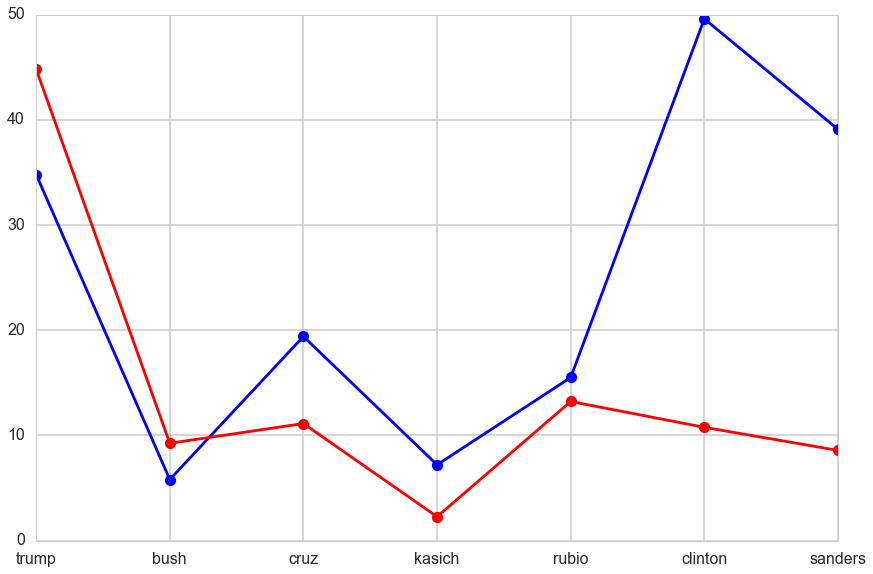

In [156]:
# 538 Polling averages from 2/21/16 
# ['trump','bush','cruz','kasich','rubio','clinton','sanders']
avg_538 = [34.8, 5.8, 19.4, 7.2, 15.5, 49.6, 39.1]
# correlate with the number of tweets 
numTweets_538_pearson_corr = np.corrcoef(avg_538,candidate_tweets)
print(numTweets_538_pearson_corr[0][1])
num_tweet_array = np.array(candidate_tweets)
proportion_tweets = (num_tweet_array/num_tweet_array.sum())*100


plt.plot(ind,avg_538,c='b',marker = 'o')
plt.plot(ind,proportion_tweets,c='r',marker='o')
plt.xticks(ind, candidates)
sns.set_context("poster")
plt.show;
# print('cross correlation between Real Clear Politics Favorable/Unfavorable ratings and Positive/Negative:',
#      rcp_pos_corr[0])
print('correlation coefficient between 538 Avg Polls and Number of Tweets:',
     numTweets_538_pearson_corr[0][1])



now looking at correlation of the two polls, seems like the democrats are really not tracking the same way as the republicans, so looked at only republicans: 

In [157]:
rep_numTweets_538_pearson_corr = np.corrcoef(avg_538[:4],candidate_tweets[:4])
print('republican only correlation coefficient between 538 Avg Polls and Number of Tweets:',
     rep_numTweets_538_pearson_corr[0][1])

republican only correlation coefficient between 538 Avg Polls and Number of Tweets: 0.926823934978


## Plot geographical coordinates of tweets

In [ ]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

In [ ]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

In [ ]:
rcParams['figure.figsize'] = (20,20)

 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
# my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
# my_map = Basemap(projection='robin', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
my_map = Basemap(projection='merc', lat_0=42.36, lon_0=-71.06,
              resolution='h', area_thresh=.01, 
              llcrnrlon=-71.3, llcrnrlat=42.1,
              urcrnrlon=-70.9, urcrnrlat=42.6) 
#               llcrnrlon=-71.098709, llcrnrlat=42.328093,
#               urcrnrlon=-71.012192, urcrnrlat=42.389994) 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='#66CC99')
my_map.drawstates(linewidth = .5)
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.drawcounties(linewidth = 0.5)

# lon = -135.3318
# lat = 57.0799
# x,y = my_map(lon, lat)
# my_map.plot(x, y, 'bo', markersize=12)
i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = my_map(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = my_map(xpt,ypt,inverse=True)
    my_map.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()